---
title: "US Treasury Par Yield Curve Rates Analysis"
format: 
  html:
    code-fold: true
---

### Let's get started!
This analysis is performed using Python in a Jupyter Notebook environment. Ensure you have the following libraries installed:

* pandas
* datetime
* numpy
* requests
* matplotlib
* beautifulsoup4
* seaborn
* matplotlib

### Extracting the Data via Web Scraping
Data is scrapped from the [U.S. Department of the Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/selected-interest-rates-historical-data).
Date range: 1990 to Present

Use the first URL to inspect the table structure, and get the table headings, then loop through all the URLs to get the table data.

In [2]:
from bs4 import BeautifulSoup as BS
import requests as req
import datetime
import pandas as pd
import numpy as np

urls=[]
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=xxxx"

start_year = 1990
end_year = datetime.date.today().year

years = [str(yr) for yr in range(start_year, end_year+1)]

for year in years:
    urls.append(url.replace('xxxx', year))

# inspect the first URL to get the table headings
html_text = req.get(urls[0]).text
soup=BS(html_text, 'html.parser')

print('Scrapping from website:', soup.title.text)
print(f'This script is to scrap US Treasury Rate data from {start_year} to {end_year}.')

# column headings
headings = []
# table = soup.find('table', class_ = 'usa-table views-table views-view-table cols-26') 
# table_rows = table.find_all('tr')

for item in soup.find_all('th'):
    headings.append(item.text)
# print('Table headings <th>:', headings)

# now scrap all the table data/ td from all the URLs
all_rows = []
for url in urls:
    html_text = req.get(url).text
    soup = BS(html_text, 'html.parser')
    table_rows = soup.find_all('tr')               
    for tr in table_rows[1:]:
        td = tr.find_all('td')
        row=[i.text.strip('\n') for i in td]       #i is each td element, i.text is to find all text in that i, .strip to remove entries starts with \n
        all_rows.append(row)
df=pd.DataFrame(data=all_rows, columns=headings)

# df.to_csv('raw_US_Treasury_Rates.csv', index=False)

Scrapping from website: Resource Center | U.S. Department of the Treasury
This script is to scrap US Treasury Rate data from 1990 to 2025.


### Reviewing and Cleaning the Data

Inspecting dataframe via `df.describe()`, `df.info()` and `df.head()`.
First table shows the summary statistics of the numerical columns, while the second table shows the first few rows of the dataframe.

In [17]:
display(df.describe(), df.head())
# noticed there are space in N/A cell, 
# print("N/A cell: '", df['20 YR'][0], "'")

,Date,20 YR,30 YR,Extrapolation Factor,6 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,8941,8941,8941,8941,8941,8941,8941,8941,8941,8941,...,8941,8941,8941,8941,8941,8941,8941,8941,8941,8941
unique,8941,1,1,1,1,1,1,1,1,1,...,144,763,806,844,855,850,848,836,716,789
top,01/02/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,0.06,0.11,0.27,0.35,1.66,2.02,4.27,N/A,N/A
freq,1,8941,8941,8941,8941,8941,8941,8941,8941,8941,...,8207,183,176,98,54,35,35,36,940,995


,Date,20 YR,30 YR,Extrapolation Factor,6 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,COUPON EQUIVALENT,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,01/02/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,7.89,7.81,7.87,7.90,7.87,7.98,7.94,N/A,8.00
1,01/03/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,7.94,7.85,7.94,7.96,7.92,8.04,7.99,N/A,8.04
2,01/04/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,7.90,7.82,7.92,7.93,7.91,8.02,7.98,N/A,8.04
3,01/05/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,7.85,7.79,7.90,7.94,7.92,8.03,7.99,N/A,8.06
4,01/08/1990,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,7.88,7.81,7.90,7.95,7.92,8.05,8.02,N/A,8.09


To-do list:
1. Remove leading and trailing spaces
2. Replace all 'N/A' with NaN
3. Drop columns with all NaN values
4. convert the 'Date' column to datetime format
5. convert the rest of the columns to float

##### All done! Ready for analysis.

In [4]:
# remove all blank spaces in the dataframe, except headers
clean_df = df.iloc[:,:].map(lambda x:x.strip())
# converting to lower case, if cell equals to 'n/a', then replace with empty string
clean_df = clean_df.map(lambda x:np.nan if (x.lower() == 'n/a' or x =='') else x)
# dropping all columns with all NaN values
clean_df.dropna(axis=1, how='all', inplace=True)
# change Date column to datetime and the rest to float
clean_df[clean_df.columns[0]] = pd.to_datetime(clean_df[clean_df.columns[0]])
for col in clean_df.columns[1:]:
    clean_df[col] = clean_df[col].astype(str).astype(float)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8941 entries, 0 to 8940
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8941 non-null   datetime64[ns]
 1   1 Mo    6041 non-null   float64       
 2   1.5 Mo  153 non-null    float64       
 3   2 Mo    1736 non-null   float64       
 4   3 Mo    8937 non-null   float64       
 5   4 Mo    734 non-null    float64       
 6   6 Mo    8940 non-null   float64       
 7   1 Yr    8940 non-null   float64       
 8   2 Yr    8940 non-null   float64       
 9   3 Yr    8940 non-null   float64       
 10  5 Yr    8940 non-null   float64       
 11  7 Yr    8940 non-null   float64       
 12  10 Yr   8940 non-null   float64       
 13  20 Yr   8001 non-null   float64       
 14  30 Yr   7946 non-null   float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 1.0 MB


### Initial observations
#### I choose you, Seaborn and Matplotlib!
#### Data Distribution

Utilizing seaborn and matplotlib, we will visualize the trends and distribution in the U.S. Treasury Par Yield Curve Rates over time.

Box plots allows us to view the distribution of rates for each maturity period.
We can also observe that the short term rates has generally a lower rate than the long term rates, which is expected.

1.5Mo and 4Mo maturity rate have significantly smaller range of data. Upon review, it appears that the 1.5Mo and 4Mo maturity rates were only added to the dataset in recent years, which has less data points compared to other rates. 

[Text(0, 0.5, '')]

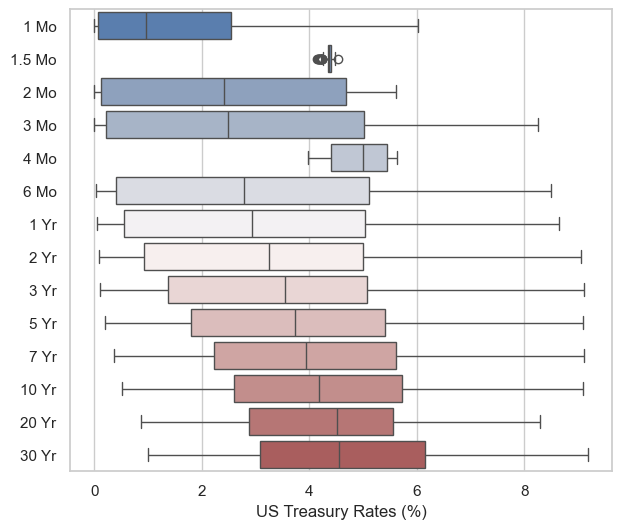

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt df to long format
data = clean_df.melt(id_vars='Date', var_name='Series', value_name='Value')
data.dropna(inplace=True)

f, ax = plt.subplots(figsize=(7, 6))
# Plot the orbital period with horizontal boxes, vlag - blue/pink diverging color palette
sns.boxplot(
    data, x="Value", y="Series", hue="Series", palette="vlag"
)

ax.set_xlabel("US Treasury Rates (%)")
ax.xaxis.grid(True)
ax.set(ylabel="")

#### Trends Over Time

The line chart below shows the trends of different maturity rates from 1990 to 2024 are generally trending down.
The more volatile rates are the short-term rates (1 month, 3 month, 6 month, 1 year), while the long-term rates (10 year, 20 year, 30 year) are more stable.
There are a few period that the short-term rates spike above the long-term rates, indicating an inverted yield curve, which we will explore this further.

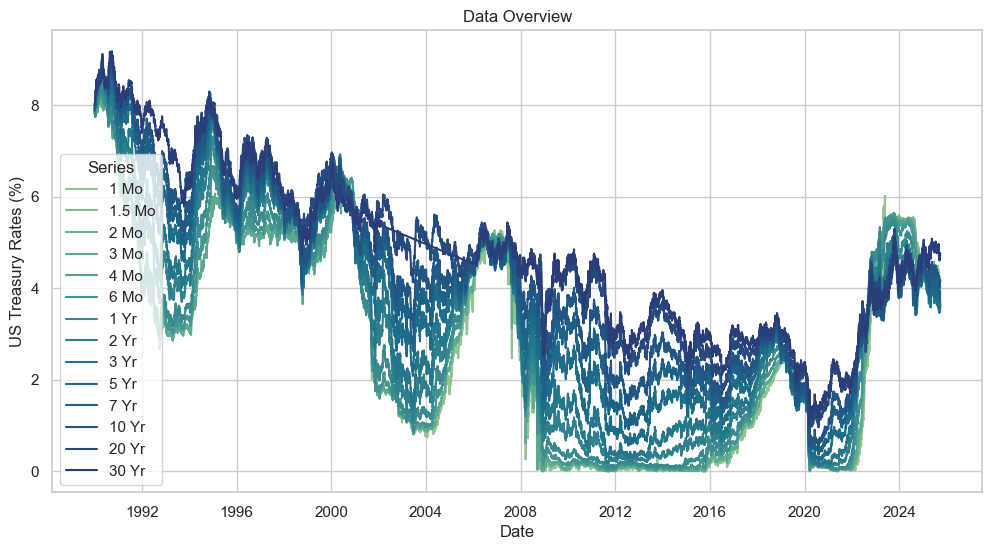

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Value', hue='Series', palette='crest')
plt.title("Data Overview")
plt.ylabel("US Treasury Rates (%)")
# plt.
plt.show()

### What is Inverted Yield Curve?

"When short-term rates are higher than long-term rates."
Economists use the yield curve, which compares the interest rates difference bweteen "10-year and 3-month" or "10-year and 2-year" treasury rate, to determine if short-term investments are more profitable than long-term ones. When the yield curve inverts and the difference drops below zero, it serves as a warning sign of an impending recession.

The assumption of recession is supported by the last 30 years of invasion occurrences.
Recession happened in early 2000 (dot-com bubble), 2007-2009 (housing bubble), and 2020 (pendemic). The 3 recessions mentioned experienced a decrease below 0.

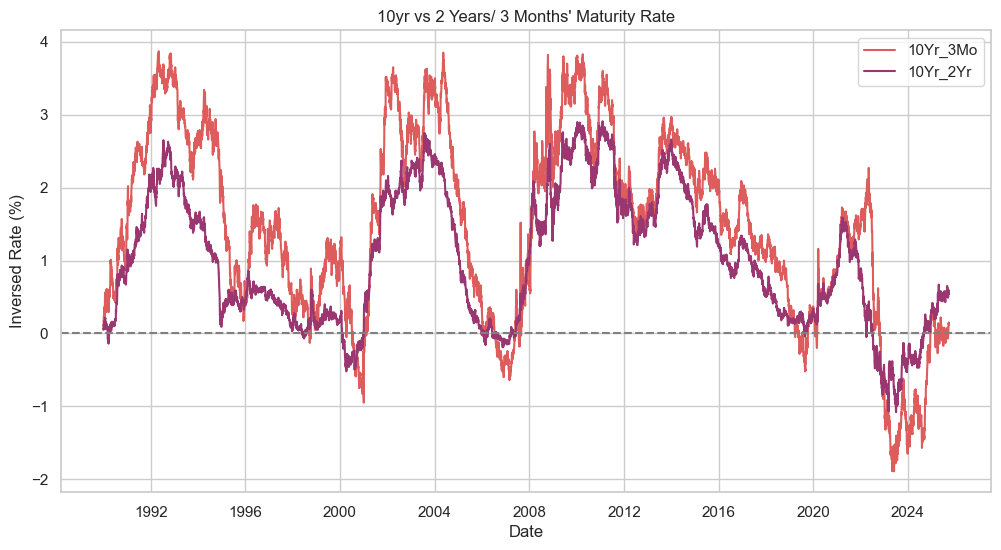

In [ ]:
#calculate the inversed rate
clean_df['10Yr_3Mo'] = clean_df['10 Yr']-clean_df['3 Mo']
clean_df['10Yr_2Yr'] = clean_df['10 Yr']-clean_df['2 Yr']

data = clean_df.melt(id_vars='Date', var_name='Series', value_name='Value')
data.dropna(inplace=True)
data = data[data['Series'].isin(['10Yr_3Mo', '10Yr_2Yr'])]

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='Value', hue='Series', palette='flare')
plt.title("10yr vs 2 Years/ 3 Months' Maturity Rate")
plt.ylabel("Inversed Rate (%)")
plt.legend(loc="upper right")
plt.axhline(y=0, color='grey',linestyle='--')
plt.show()

~~UNDER CONSTRUCTION~~